## 3b. Entrenamiento modelo Deep Learning

En este notebook implementaremos y compararemos dos modelos de Deep Learning:
1. **GRU**: Versión eficiente de LSTM con menos parámetros, más rápido, bien para dataset pequeños
2. **LSTM con Word2Vec**: Modelo estándar con embeddings pre-entrenados para capturar relacion semantica.

### 3.1 Carga de datos y setup

In [27]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Dense, Dropout, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Usar keras_preprocessing (compatible con Keras 3)
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

from gensim.models import Word2Vec


### 3.2 Carga de Datos Preprocesados

In [2]:
# Cargar datos preprocesados del Notebook 2
df = pd.read_pickle('Outputs/data/df_beauty_preprocessed_DL.pkl')

print(f"Dataset cargado: {len(df):,} reviews")
df.head()

Dataset cargado: 5,995 reviews


,review_processed_DL,label_sentiment
0,sculpting crean use this product and find that...,0
1,keep your money foe the price one expects more...,1
2,fell apart after year was good while lasted bu...,1
3,five stars works beautifully great for clients...,0
4,worst product recently purchased this product ...,1


In [3]:
# Preparar datos para Deep Learning
X = df['review_processed_DL'].values
y = df['label_sentiment'].values

print(f"Total de reviews: {len(X):,}")
print(f"\nDistribución de sentimiento:")
print(pd.Series(y).value_counts())
print(f"\nEjemplo de texto preprocesado:")
print(X[0][:200])

Total de reviews: 5,995

Distribución de sentimiento:
1    3000
0    2995
dtype: int64

Ejemplo de texto preprocesado:
sculpting crean use this product and find that when run out notice the difference the tautness skin especially around mouth and neck


### 3.3 Tokenización y Preparación de Secuencias

**Parámetros justificados para dataset de belleza (~6K reviews):**
- **vocab_size = 5000**: Balance entre cobertura y eficiencia
- **max_length = 100**: Longitud promedio de reviews de productos
- **embedding_dim = 128**: Dimensión estándar para Word2Vec

In [4]:
# Parámetros de tokenización
VOCAB_SIZE = 5000  # Vocabulario limitado para evitar overfitting
MAX_LENGTH = 100   # Longitud máxima de secuencia
EMBEDDING_DIM = 128  # Dimensión de embeddings (debe coincidir con Word2Vec)

# Tokenizer de Keras
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

# Convertir textos a secuencias numéricas
sequences = tokenizer.texts_to_sequences(X)

# Padding: todas las secuencias deben tener la misma longitud
X_padded = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

print(f"Vocabulario total: {len(tokenizer.word_index):,} palabras únicas")
print(f"Vocabulario usado: {VOCAB_SIZE:,} palabras")
print(f"Forma de X_padded: {X_padded.shape}")
print(f"\nEjemplo de transformación:")
print(f"Original: {X[0][:100]}...")
print(f"Secuencia: {sequences[0][:20]}...")
print(f"Padded: {X_padded[0][:20]}...")

Vocabulario total: 10,734 palabras únicas
Vocabulario usado: 5,000 palabras
Forma de X_padded: (5995, 100)

Ejemplo de transformación:
Original: sculpting crean use this product and find that when run out notice the difference the tautness skin ...
Secuencia: [3264, 1, 22, 4, 10, 3, 199, 11, 36, 674, 29, 861, 2, 366, 2, 1, 43, 378, 188, 690]...
Padded: [3264    1   22    4   10    3  199   11   36  674   29  861    2  366
    2    1   43  378  188  690]...


### 3.4 División Train/Validation/Test

- **Train**: 70% para entrenamiento
- **Validation**: 15% para ajuste de hiperparámetros y early stopping
- **Test**: 15% para evaluación final

In [5]:
# Primera división: Train+Val (85%) vs Test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_padded, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)

# Segunda división: Train (70%) vs Val (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=RANDOM_STATE, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

print("="*60)
print("DIVISIÓN DE DATOS")
print("="*60)
print(f"Train: {len(X_train):,} samples ({len(X_train)/len(X_padded)*100:.1f}%)")
print(f"Validation: {len(X_val):,} samples ({len(X_val)/len(X_padded)*100:.1f}%)")
print(f"Test: {len(X_test):,} samples ({len(X_test)/len(X_padded)*100:.1f}%)")
print(f"\nDistribución en Train: Positivos={np.sum(y_train==0)}, Negativos={np.sum(y_train==1)}")
print(f"Distribución en Val: Positivos={np.sum(y_val==0)}, Negativos={np.sum(y_val==1)}")
print(f"Distribución en Test: Positivos={np.sum(y_test==0)}, Negativos={np.sum(y_test==1)}")

DIVISIÓN DE DATOS
Train: 4,198 samples (70.0%)
Validation: 897 samples (15.0%)
Test: 900 samples (15.0%)

Distribución en Train: Positivos=2097, Negativos=2101
Distribución en Val: Positivos=448, Negativos=449
Distribución en Test: Positivos=450, Negativos=450


### 3.5 Entrenamiento de Word2Vec (Propósito Didáctico)

#### ¿Por qué Word2Vec?

Word2Vec es una técnica de **word embeddings** que convierte palabras en vectores densos. A diferencia de embeddings aleatorios (Keras por defecto), Word2Vec aprende representaciones semánticas:

**Ventajas Didácticas:**
- **Captura similitud semántica**: Palabras similares → vectores cercanos
- **Relaciones contextuales**: "good" y "great" estarán cerca
- **Visualizable**: Podemos explorar similitudes
- **Pre-entrenado**: Los embeddings se entrenan ANTES de LSTM

**Parámetros:**
- **vector_size=128**: Dimensión (coincide con EMBEDDING_DIM)
- **window=5**: Contexto de palabras vecinas
- **min_count=2**: Palabras que aparecen ≥2 veces
- **sg=1**: Skip-gram (mejor para datasets pequeños)

In [6]:
# Preparar datos para Word2Vec (necesita lista de listas de palabras)
print("Preparando datos para Word2Vec...")
sentences = [text.split() for text in X]  # Convertir textos a listas de palabras

print(f"✓ Total de reviews: {len(sentences):,}")
print(f"✓ Ejemplo de sentencia: {sentences[0][:15]}...")

# Entrenar Word2Vec
print("\nEntrenando Word2Vec...")
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=EMBEDDING_DIM,  # Debe coincidir con EMBEDDING_DIM
    window=5,                    # Contexto de 5 palabras
    min_count=2,                 # Palabras que aparecen al menos 2 veces
    workers=4,                   # Procesamiento paralelo
    sg=1,                        # Skip-gram (mejor para datasets pequeños)
    epochs=10,                   # Número de épocas de entrenamiento
    seed=RANDOM_STATE
)

print(f"\n✓ Word2Vec entrenado")
print(f"✓ Vocabulario Word2Vec: {len(w2v_model.wv):,} palabras")

# Guardar modelo Word2Vec
os.makedirs('Outputs/models', exist_ok=True)
w2v_model.save('Outputs/models/word2vec_beauty.model')
print("✓ Modelo Word2Vec guardado en outputs/models/word2vec_beauty.model")

Preparando datos para Word2Vec...
✓ Total de reviews: 5,995
✓ Ejemplo de sentencia: ['sculpting', 'crean', 'use', 'this', 'product', 'and', 'find', 'that', 'when', 'run', 'out', 'notice', 'the', 'difference', 'the']...

Entrenando Word2Vec...

✓ Word2Vec entrenado
✓ Vocabulario Word2Vec: 5,544 palabras
✓ Modelo Word2Vec guardado en outputs/models/word2vec_beauty.model


In [7]:
# Explorar similitudes (Propósito Didáctico)
print("="*60)
print("EXPLORACIÓN DE WORD2VEC - SIMILITUDES SEMÁNTICAS")
print("="*60)

# Palabras de ejemplo relacionadas con sentiment
test_words = ['good', 'bad', 'love', 'hate', 'quality', 'price', 'product', 'recommend']

for word in test_words:
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=5)
        print(f"\n'{word}' es similar a:")
        for sim_word, score in similar:
            print(f"  - {sim_word}: {score:.3f}")
    else:
        print(f"\n'{word}' no está en el vocabulario")

EXPLORACIÓN DE WORD2VEC - SIMILITUDES SEMÁNTICAS

'good' es similar a:
  - great: 0.755
  - low: 0.747
  - bargain: 0.743
  - suggested: 0.731
  - reasonable: 0.729

'bad' es similar a:
  - funky: 0.702
  - batch: 0.698
  - news: 0.690
  - cheep: 0.688
  - negative: 0.681

'love' es similar a:
  - fantastic: 0.718
  - awesome: 0.713
  - amazing: 0.706
  - starter: 0.699
  - fun: 0.696

'hate' es similar a:
  - miss: 0.903
  - shortvery: 0.893
  - bummed: 0.888
  - sparse: 0.884
  - reordered: 0.884

'quality' es similar a:
  - design: 0.694
  - stitching: 0.674
  - theory: 0.671
  - poor: 0.668
  - bowl: 0.664

'price' es similar a:
  - reasonable: 0.781
  - deal: 0.766
  - cost: 0.733
  - value: 0.730
  - tag: 0.730

'product' es similar a:
  - satisfied: 0.726
  - expectations: 0.714
  - item: 0.708
  - reports: 0.706
  - reviewing: 0.703

'recommend' es similar a:
  - anyone: 0.728
  - highly: 0.661
  - reccomend: 0.658
  - def: 0.641
  - dumb: 0.641


In [8]:
# Crear matriz de embeddings desde Word2Vec
print("\nCreando matriz de embeddings desde Word2Vec...")

# Inicializar matriz con ceros
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Llenar matriz con vectores de Word2Vec
words_found = 0
for word, idx in tokenizer.word_index.items():
    if idx < VOCAB_SIZE:  # Solo palabras en nuestro vocabulario
        if word in w2v_model.wv:
            embedding_matrix[idx] = w2v_model.wv[word]
            words_found += 1

coverage = (words_found / VOCAB_SIZE) * 100
print(f"\n✓ Matriz de embeddings creada: {embedding_matrix.shape}")
print(f"✓ Palabras encontradas en Word2Vec: {words_found:,}/{VOCAB_SIZE:,} ({coverage:.1f}%)")
print(f"✓ Palabras sin embedding (inicializadas a cero): {VOCAB_SIZE - words_found:,}")


Creando matriz de embeddings desde Word2Vec...

✓ Matriz de embeddings creada: (5000, 128)
✓ Palabras encontradas en Word2Vec: 4,998/5,000 (100.0%)
✓ Palabras sin embedding (inicializadas a cero): 2


### 3.6 Modelo 1: GRU

**Arquitectura:**
1. **Embedding Layer**: Usa embeddings de Word2Vec (trainable=False)
2. **SpatialDropout1D**: Regularización para embeddings (20%)
3. **GRU**: 64 unidades, captura dependencias temporales
4. **Dropout**: Regularización (50%)
5. **Dense**: Capa de salida con sigmoid

**Justificación de Parámetros:**
- **GRU units=64**: Balance entre capacidad y overfitting para ~4K samples
- **Dropout=0.5**: Regularización fuerte para evitar overfitting
- **trainable=False**: Mantener embeddings Word2Vec fijos (didáctico)

In [11]:
# Construir modelo GRU con Word2Vec embeddings
def build_gru_model(embedding_matrix):
    model = Sequential([
        # Embedding layer con pesos de Word2Vec
        Embedding(
            VOCAB_SIZE, 
            EMBEDDING_DIM, 
            weights=[embedding_matrix],  # Usar embeddings de Word2Vec
            input_length=MAX_LENGTH,
            trainable=False  # No entrenar embeddings (usar Word2Vec tal cual)
        ),
        SpatialDropout1D(0.2),
        GRU(64, dropout=0.2, recurrent_dropout=0.2),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    return model

gru_model = build_gru_model(embedding_matrix)
print(gru_model.summary())

print("\n✓ Modelo GRU creado con embeddings de Word2Vec")
print("✓ Embeddings NO entrenables (trainable=False) - usamos Word2Vec tal cual")

/usr/local/anaconda3/envs/nlp-dl-stable/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,000 (2.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 640,000 (2.44 MB)

None

✓ Modelo GRU creado con embeddings de Word2Vec
✓ Embeddings NO entrenables (trainable=False) - usamos Word2Vec tal cual


In [14]:
# Callbacks para GRU
gru_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'outputs/models/gru_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Entrenar GRU
print("Entrenando modelo GRU...")
print("="*60)

BATCH_SIZE = 32
EPOCHS = 20

gru_history = gru_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=gru_callbacks,
    verbose=1
)

print("\n✓ Entrenamiento GRU completado")

Entrenando modelo GRU...
Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5001 - loss: 0.6923 - precision: 0.4973 - recall: 0.7118
Epoch 1: val_accuracy improved from None to 0.50725, saving model to outputs/models/gru_best.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.5031 - loss: 0.6921 - precision: 0.5030 - recall: 0.5926 - val_accuracy: 0.5072 - val_loss: 0.6920 - val_precision: 0.5040 - val_recall: 0.9733 - learning_rate: 0.0010
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4968 - loss: 0.6919 - precision: 0.5001 - recall: 0.7820
Epoch 2: val_accuracy did not improve from 0.50725
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5026 - loss: 0.6910 - precision: 0.5022 - recall: 0.7068 - val_accuracy: 0.5006 - val_loss: 0.6916 - val_precision: 1.0000 - val_recall: 0.0022 - learning_rate: 0.0010
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5129 - loss: 0.6903 - precision: 0.4932 - recall: 0.2689
Epoch 3: val_accuracy improved from 0.50725 to 0.51059, saving model to outputs/models/gru_best.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5088 - loss: 0.6904 - precision: 0.5102 - recall: 0.4622 - val_accuracy: 0.5106 - val_loss: 0.6920 - val_precision: 0.5058 - val_recall: 0.9777 - learning_rate: 0.0010
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5051 - loss: 0.6911 - precision: 0.4958 - recall: 0.7019
Epoch 4: val_accuracy did not improve from 0.51059
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5124 - loss: 0.6893 - precision: 0.5111 - recall: 0.5907 - val_accuracy: 0.5084 - val_loss: 0.6949 - val_precision: 0.5045 - val_recall: 0.9911 - learning_rate: 0.0010
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4955 - loss: 0.6886 - precision: 0.4917 - recall: 0.6682
Epoch 5: val_accuracy did not improve from 0.51059
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.4993 - loss: 0.6901 - precision: 0.4998 - recall: 0.6168 - val_accuracy: 0.5050 - val_loss: 0.6914 - val_precision: 0.5029 - val_recall: 0.9733 - 

### 3.7 Modelo 2: LSTM con Word2Vec

**Arquitectura:**
Similar a GRU pero con LSTM (más parámetros)

**Ventajas de LSTM:**
- **Más parámetros**: Mayor capacidad de aprendizaje
- **Mejor para secuencias largas**: Captura dependencias complejas
- **Estándar de la industria**: LSTM es el modelo más usado
- **Maneja negaciones**: Mejor contexto para sentiment analysis

In [15]:
# Construir modelo LSTM con Word2Vec embeddings
def build_lstm_model(embedding_matrix):
    model = Sequential([
        # Embedding layer con pesos de Word2Vec
        Embedding(
            VOCAB_SIZE, 
            EMBEDDING_DIM, 
            weights=[embedding_matrix],  # Usar embeddings de Word2Vec
            input_length=MAX_LENGTH,
            trainable=False  # No entrenar embeddings (usar Word2Vec tal cual)
        ),
        SpatialDropout1D(0.2),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    return model

lstm_model = build_lstm_model(embedding_matrix)
print(lstm_model.summary())

print("\n✓ Modelo LSTM creado con embeddings de Word2Vec")
print("✓ Embeddings NO entrenables (trainable=False) - usamos Word2Vec tal cual")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,000 (2.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 640,000 (2.44 MB)

None

✓ Modelo LSTM creado con embeddings de Word2Vec
✓ Embeddings NO entrenables (trainable=False) - usamos Word2Vec tal cual


In [16]:
# Callbacks para LSTM
lstm_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'outputs/models/lstm_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Entrenar LSTM
print("Entrenando modelo LSTM...")
print("="*60)

lstm_history = lstm_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=lstm_callbacks,
    verbose=1
)

print("\n✓ Entrenamiento LSTM completado")

Entrenando modelo LSTM...
Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4896 - loss: 0.6931 - precision_1: 0.4843 - recall_1: 0.5229
Epoch 1: val_accuracy improved from None to 0.49944, saving model to outputs/models/lstm_best.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.4895 - loss: 0.6930 - precision_1: 0.4892 - recall_1: 0.4517 - val_accuracy: 0.4994 - val_loss: 0.6939 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5004 - loss: 0.6910 - precision_1: 0.4803 - recall_1: 0.5422
Epoch 2: val_accuracy improved from 0.49944 to 0.50167, saving model to outputs/models/lstm_best.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.5002 - loss: 0.6915 - precision_1: 0.5005 - recall_1: 0.6816 - val_accuracy: 0.5017 - val_loss: 0.6924 - val_precision_1: 1.0000 - val_recall_1: 0.0045 - learning_rate: 0.0010
Epoch 3/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4991 - loss: 0.6903 - precision_1: 0.5013 - recall_1: 0.6287
Epoch 3: val_accuracy improved from 0.50167 to 0.50725, saving model to outputs/models/lstm_best.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.4995 - loss: 0.6914 - precision_1: 0.5000 - recall_1: 0.7649 - val_accuracy: 0.5072 - val_loss: 0.6922 - val_precision_1: 0.5040 - val_recall_1: 0.9710 - learning_rate: 0.0010
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4994 - loss: 0.6904 - precision_1: 0.4840 - recall_1: 0.4002
Epoch 4: val_accuracy improved from 0.50725 to 0.50948, saving model to outputs/models/lstm_best.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.4983 - loss: 0.6911 - precision_1: 0.4990 - recall_1: 0.6235 - val_accuracy: 0.5095 - val_loss: 0.6925 - val_precision_1: 0.5052 - val_recall_1: 0.9666 - learning_rate: 0.0010
Epoch 5/20
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5123 - loss: 0.6892 - precision_1: 0.5114 - recall_1: 0.6474
Epoch 5: val_accuracy did not improve from 0.50948
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.5067 - loss: 0.6907 - precision_1: 0.5049 - recall_1: 0.7430 - val_accuracy: 0.5039 - val_loss: 0.6927 - val_precision_1: 0.6000 - val_recall_1: 0.0267 - learning_rate: 0.0010
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5088 - loss: 0.6886 - precision_1: 0.5216 - recall_1: 0.4382
Epoch 6: val_accuracy did not improve from 0.50948

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.5141 - loss: 0.6893 - precision_1: 0.5132 - r

### 3.8 Evaluación de Modelos en Test Set

In [19]:
# Evaluación GRU
print("="*60)
print("EVALUACIÓN GRU EN TEST SET")
print("="*60)

# Predicciones
y_pred_gru_proba = gru_model.predict(X_test)
y_pred_gru = (y_pred_gru_proba > 0.5).astype(int).flatten()

# Métricas
gru_accuracy = accuracy_score(y_test, y_pred_gru)
gru_precision = precision_score(y_test, y_pred_gru)
gru_recall = recall_score(y_test, y_pred_gru)
gru_f1 = f1_score(y_test, y_pred_gru)
gru_auc = roc_auc_score(y_test, y_pred_gru_proba)

print(f"\nAccuracy:  {gru_accuracy:.4f}")
print(f"Precision: {gru_precision:.4f}")
print(f"Recall:    {gru_recall:.4f}")
print(f"F1-Score:  {gru_f1:.4f}")
print(f"ROC-AUC:   {gru_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gru, target_names=['Positive', 'Negative']))

EVALUACIÓN GRU EN TEST SET
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Accuracy:  0.5133
Precision: 0.5070
Recall:    0.9711
F1-Score:  0.6662
ROC-AUC:   0.5338

Classification Report:
              precision    recall  f1-score   support

    Positive       0.66      0.06      0.10       450
    Negative       0.51      0.97      0.67       450

    accuracy                           0.51       900
   macro avg       0.58      0.51      0.38       900
weighted avg       0.58      0.51      0.38       900



In [20]:
# Evaluación LSTM
print("="*60)
print("EVALUACIÓN LSTM EN TEST SET")
print("="*60)

# Predicciones
y_pred_lstm_proba = lstm_model.predict(X_test)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int).flatten()

# Métricas
lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
lstm_precision = precision_score(y_test, y_pred_lstm)
lstm_recall = recall_score(y_test, y_pred_lstm)
lstm_f1 = f1_score(y_test, y_pred_lstm)
lstm_auc = roc_auc_score(y_test, y_pred_lstm_proba)

print(f"\nAccuracy:  {lstm_accuracy:.4f}")
print(f"Precision: {lstm_precision:.4f}")
print(f"Recall:    {lstm_recall:.4f}")
print(f"F1-Score:  {lstm_f1:.4f}")
print(f"ROC-AUC:   {lstm_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=['Positive', 'Negative']))

EVALUACIÓN LSTM EN TEST SET
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Accuracy:  0.5211
Precision: 0.5111
Recall:    0.9689
F1-Score:  0.6692
ROC-AUC:   0.5739

Classification Report:
              precision    recall  f1-score   support

    Positive       0.70      0.07      0.13       450
    Negative       0.51      0.97      0.67       450

    accuracy                           0.52       900
   macro avg       0.61      0.52      0.40       900
weighted avg       0.61      0.52      0.40       900



### 3.9 Comparación Final: GRU vs LSTM

In [21]:
# Tabla comparativa
results_dl = pd.DataFrame({
    'Model': ['GRU', 'LSTM + Word2Vec'],
    'Accuracy': [gru_accuracy, lstm_accuracy],
    'Precision': [gru_precision, lstm_precision],
    'Recall': [gru_recall, lstm_recall],
    'F1-Score': [gru_f1, lstm_f1],
    'ROC-AUC': [gru_auc, lstm_auc]
})

print("="*60)
print("COMPARACIÓN GRU vs LSTM + Word2Vec")
print("="*60)
print(results_dl.to_string(index=False))

# Identificar mejor modelo
best_model_idx = results_dl['F1-Score'].idxmax()
best_model_name = results_dl.loc[best_model_idx, 'Model']
best_f1 = results_dl.loc[best_model_idx, 'F1-Score']

print(f"\n✓ Mejor modelo: {best_model_name} (F1-Score: {best_f1:.4f})")

# Guardar resultados
results_dl.to_csv('outputs/results_deep_learning.csv', index=False)
print("✓ Resultados guardados en outputs/results_deep_learning.csv")

COMPARACIÓN GRU vs LSTM + Word2Vec
          Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
            GRU  0.513333   0.506961 0.971111  0.666159 0.533780
LSTM + Word2Vec  0.521111   0.511137 0.968889  0.669225 0.573904

✓ Mejor modelo: LSTM + Word2Vec (F1-Score: 0.6692)
✓ Resultados guardados en outputs/results_deep_learning.csv


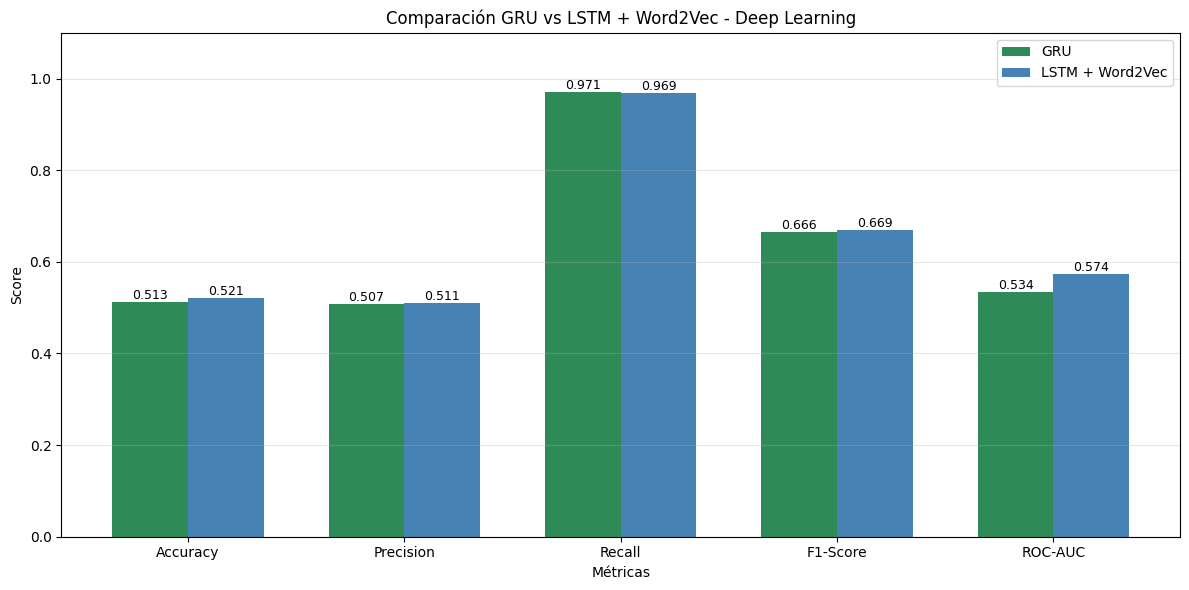

In [25]:
# Visualización comparativa
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.35

gru_scores = [gru_accuracy, gru_precision, gru_recall, gru_f1, gru_auc]
lstm_scores = [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_auc]

bars1 = ax.bar(x - width/2, gru_scores, width, label='GRU', color='seagreen')
bars2 = ax.bar(x + width/2, lstm_scores, width, label='LSTM + Word2Vec', color='steelblue')

# Añadir valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Métricas')
ax.set_ylabel('Score')
ax.set_title('Comparación GRU vs LSTM + Word2Vec - Deep Learning')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



### 3.10 Conclusiones

#### Sobre Word2Vec:
- **Ventajas**: Captura relaciones semánticas, palabras similares tienen vectores cercanos
- **Limitaciones**: Requiere corpus grande, palabras OOV se inicializan a cero

#### Comparación GRU vs LSTM:
- **GRU**: Más eficiente, menos parámetros, entrena más rápido, menos overfitting
- **LSTM**: Más parámetros, mejor para secuencias largas, estándar de la industria

#### Recomendaciones:
1. **Para datasets pequeños-medianos (~6K)**: GRU suele ser mejor opción
2. **Para reviews largas**: LSTM captura mejor las dependencias
3. **Para producción**: Considerar trade-off rendimiento vs velocidad
4. **Word2Vec**: Útil didácticamente, pero considerar embeddings pre-entrenados más grandes (GloVe, FastText, BERT) en producción

In [28]:
# Guardar modelos finales
print("Guardando modelos...")

# Guardar el mejor modelo según F1-Score
if best_model_name == 'GRU':
    gru_model.save('outputs/models/best_dl_model.h5')
    print(f"✓ Mejor modelo (GRU) guardado en outputs/models/best_dl_model.h5")
else:
    lstm_model.save('outputs/models/best_dl_model.h5')
    print(f"✓ Mejor modelo (LSTM) guardado en outputs/models/best_dl_model.h5")

# Guardar tokenizer
with open('outputs/models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Tokenizer guardado en outputs/models/tokenizer.pkl")

# Guardar embedding matrix
np.save('outputs/models/embedding_matrix.npy', embedding_matrix)
print("✓ Embedding matrix guardada en outputs/models/embedding_matrix.npy")

print("\n" + "="*60)
print("NOTEBOOK 3b COMPLETADO")
print("="*60)
print(f"✓ Modelos GRU y LSTM + Word2Vec entrenados")
print(f"✓ Mejor modelo: {best_model_name} (F1-Score: {best_f1:.4f})")
print(f"✓ Todos los resultados guardados en outputs/")

Guardando modelos...
✓ Mejor modelo (LSTM) guardado en outputs/models/best_dl_model.h5
✓ Tokenizer guardado en outputs/models/tokenizer.pkl
✓ Embedding matrix guardada en outputs/models/embedding_matrix.npy

NOTEBOOK 3b COMPLETADO
✓ Modelos GRU y LSTM + Word2Vec entrenados
✓ Mejor modelo: LSTM + Word2Vec (F1-Score: 0.6692)
✓ Todos los resultados guardados en outputs/
